In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from qutip import tensor, num, qeye, create, destroy, basis, sesolve, expect, mesolve
from compute_g0 import compute_g0
from compute_fidelity import compute_fidelity

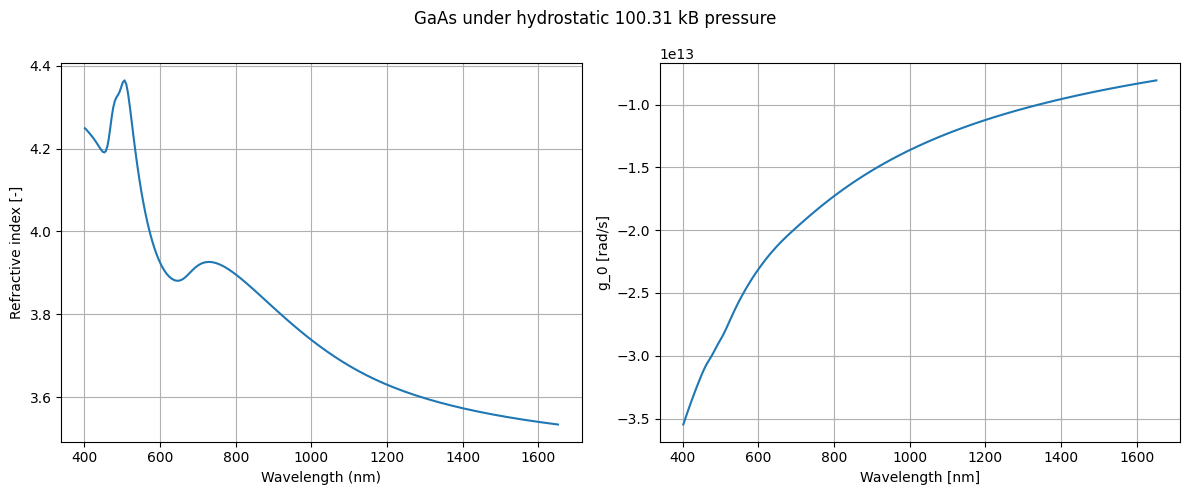

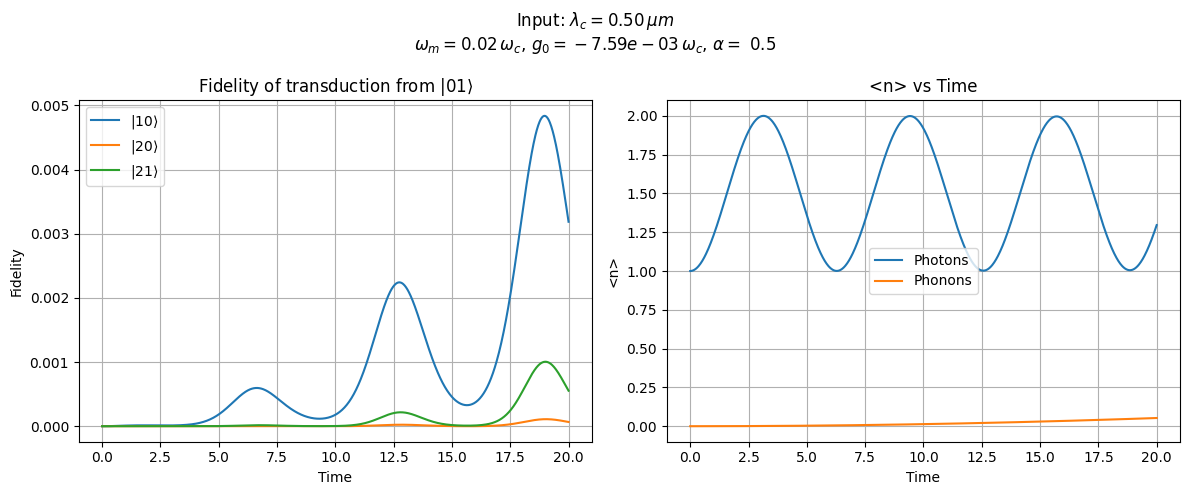

{'max_fidelity_target_state10': '4.84e-03', 'peak_time_target_state10': 18.98, 'max_fidelity_target_state20': '1.09e-04', 'peak_time_target_state20': 19.04, 'max_fidelity_target_state21': '1.01e-03', 'peak_time_target_state21': 19.0, 'max_fidelity_target_state31': '3.16e-05', 'peak_time_target_state31': 19.08, 'max_fidelity_target_state22': '1.1e-03', 'peak_time_target_state22': 19.44, 'max_fidelity_target_state42': '3.50e-06', 'peak_time_target_state42': 19.12}


In [2]:
# specify all wavelengths in micrometers
omega_array, g_0_array = compute_g0(outcar_name='OUTCAR_hydrostatic_100kB', 
        plot_min_wavelength=0.4*1e-6, plot_max_wavelength= 1.7*1e-6, plot=True,
        cavity_length= 1.05*1e-4, semiconductor_length= 1e-4)

fidelities = compute_fidelity(omega_array, g_0_array, alpha=0.5, omega_photon = 2*np.pi*3*10**8/(0.5*10**-6), omega_phonon = 2*np.pi*10**13,
                 photon_loss_rate= 0, truncation_photon_space = 5, truncation_phonon_space = 50, simulation_time= 20,
                 plot = True, set_g_0 = None)
print(fidelities)


In [15]:
# Define the ranges for omega_photon and omega_phonon
photon_wavelength = np.linspace(0.4*1e-6, 1.6*1e-6,10) # 400 - 1600 nm
omega_phonon_range = 2*np.logspace(8, 14, 10) # 100 MHz - 100 THz
cavity_length = 1.05*1e-4
semiconductor_length = 1e-4

simulation_time = 100
alpha = 0.5
photon_loss_rate = 0
truncation_photon_space = 10
truncation_phonon_space = 20

###
omega_photon_range = 2*np.pi*3*10**8/photon_wavelength
omega_array, g_0_array = compute_g0(outcar_name='OUTCAR_hydrostatic_100kB', 
        plot_min_wavelength=0.4*1e-6, plot_max_wavelength= 1.7*1e-6, plot = False,
        cavity_length=cavity_length, semiconductor_length= semiconductor_length)

# Initialize dictionaries to track the best fidelities and corresponding parameters for each state
best_fidelities = {
    "target_state10": 0,
    "target_state20": 0,
    "target_state21": 0,
    "target_state22": 0,
    "target_state31": 0,
    "target_state42": 0
}
corresponding_fidelity_times = {
    "target_state10": 0,
    "target_state20": 0,
    "target_state21": 0,
    "target_state22": 0,
    "target_state31": 0,
    "target_state42": 0
}
best_params = {
    "target_state10": None,
    "target_state20": None,
    "target_state21": None,
    "target_state22": None,
    "target_state31": None,
    "target_state42": None
}

# Initialize variables to track the best fidelity across all states
best_overall_fidelity = 0
best_overall_state = None
best_overall_time = 0
best_overall_params = None

# Loop over the parameter ranges for omega_photon and omega_phonon
for omega_photon in omega_photon_range:
    for omega_phonon in omega_phonon_range:
        result = compute_fidelity(omega_array, g_0_array, alpha,
                                  omega_photon, omega_phonon, photon_loss_rate,
                                  truncation_photon_space, truncation_phonon_space, simulation_time=simulation_time, plot=False)

        # Iterate over the states and update the best fidelities and peak times
        for state in best_fidelities:
            # Access the fidelity and peak time for the state
            max_fidelity_key = f"max_fidelity_{state}"
            peak_time_key = f"peak_time_{state}"
            
            # Check if the keys exist in the result dictionary
            if max_fidelity_key in result and peak_time_key in result:
                max_fidelity = float(result[max_fidelity_key])
                peak_time = float(result[peak_time_key])

                # Update if the current fidelity is better than the stored best for that state
                if max_fidelity > best_fidelities[state]:
                    best_fidelities[state] = max_fidelity
                    corresponding_fidelity_times[state] = peak_time
                    best_params[state] = (omega_photon, omega_phonon, f"State {state.split('_')[1]}", peak_time)

                # Also track the best fidelity across all states
                if max_fidelity > best_overall_fidelity:
                    best_overall_fidelity = max_fidelity
                    best_overall_state = state
                    best_overall_time = peak_time
                    best_overall_params = (omega_photon, omega_phonon, f"State {state.split('_')[1]}", peak_time)

# Print the best results for each state
print('Results:')
print(f'alpha = {alpha}')
# # Print the best overall fidelity across all states
# print("\nBest Overall Fidelity:")
# print(f"Best Fidelity: {np.format_float_scientific(best_overall_fidelity, precision=2)}")
# print(f"State: {best_overall_state}")
# print(f"Peak Time: {np.round(best_overall_time, 2)}")
# print(f"Photon wavelength: {np.format_float_scientific(3*10**8/(2*np.pi *best_overall_params[0]), precision=2)} m")
# print(f"Omega Phonon: {np.format_float_scientific(best_overall_params[1]/(2*np.pi), precision=2)} Hz")
# print('---')

results_data = []
for state in best_fidelities:
    results_data.append({
        "State": best_params[state][2],
        "Max Fidelity": np.format_float_scientific(best_fidelities[state], precision=2),
        "Peak Time (s)": np.round(corresponding_fidelity_times[state], 2),
        "Photon Wavelength (m)": np.format_float_scientific(3*10**8/(2*np.pi *best_params[state][0]), precision=2),
        "Omega Phonon (Hz)": np.format_float_scientific(best_params[state][1]/(2*np.pi), precision=2),
    })
df = pd.DataFrame(results_data)
df = df.set_index('Max Fidelity')
df = df.sort_index(ascending=False)
display(df)



Results:
alpha = 0.5


,State,Peak Time (s),Photon Wavelength (m),Omega Phonon (Hz)
Max Fidelity,,,,
8.85e-02,State state21,94.29,1.01e-08,3.18e+07
4.34e-02,State state22,96.40,1.01e-08,6.86e+12
4.32e-02,State state10,94.29,1.01e-08,3.18e+07
4.16e-02,State state31,100.00,1.01e-08,3.18e+07
1.75e-02,State state42,100.00,1.01e-08,3.18e+07
1.69e-02,State state20,100.00,1.01e-08,3.18e+07
